# Actividad 3.1
## Detección de Peatones con SVM

---

### Integrantes del Equipo 23:
* Carlos Pano Hernández - A01066264 [Campus Estado de México]
* Marie Kate Palau - A01705711 [Campus Monterrey]
* Edson Ulises Rodríguez Dávalos - A01796057 [Campus CdMx]
* Yohanna Ceballos Salomón - A01795115 [Campus Monterrey]

---

### Escuela de Ingeniería y Ciencias, Tecnológico de Monterrey
**Navegación autónoma (MR4010 - Gpo 10)**

---

#### Profesor Titular:
Dr. David Antonio Torres

#### Profesor Asistente:
Mtra. María Mylen Treviño Elizondo

---

**Viernes 16 de mayo del 2025**

In [23]:
# Importing main libraries
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import glob
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline

Number of pedestrian images: 79
Number of non-pedestrian images: 40
Pedestrian HOG feature sizes: [7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524]
Non-pedestrian HOG feature sizes: [7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524, 7524]


Shape of pedestrian HOG features array (X_people): (79, 7524)
Shape of pedestrian labels array (y_people): (79,)


Shape of non-pedestrian HOG feature

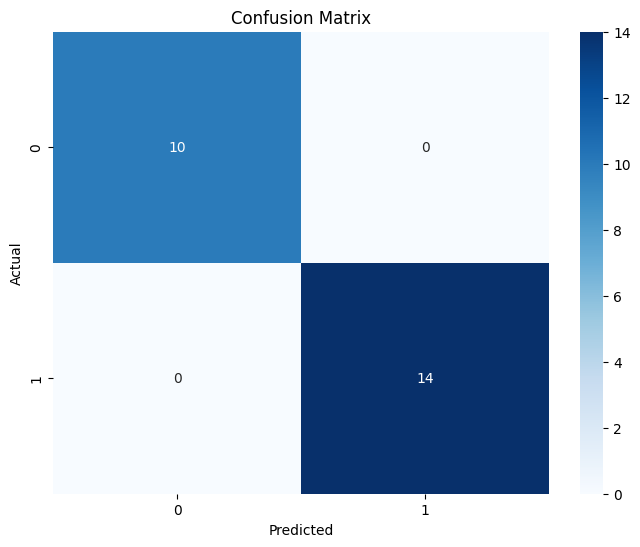

Model saved to pedestrian_detector.joblib


In [24]:
people = []
for ext in ['*.jpg', '*.png']:
    img_paths = glob.glob(f"data_copy/people/{ext}")
    for path in img_paths:
        img = cv2.imread(path)
        resized_img = cv2.resize(img, (320, 160), interpolation=cv2.INTER_AREA)
        cv2.imwrite(path, resized_img)
        people.append(path)
    
non_people = []
for ext in ['*.jpg', '*.png']:
    img_paths = glob.glob(f"data_copy/non-people/{ext}")
    for path in img_paths:
        img = cv2.imread(path)
        resized_img = cv2.resize(img, (320, 160), interpolation=cv2.INTER_AREA)
        cv2.imwrite(path, resized_img)
        non_people.append(path)

print(f"Number of pedestrian images: {len(people)}")
print(f"Number of non-pedestrian images: {len(non_people)}")

people_hog_accum = []
non_people_hog_accum = []

# Process pedestrian images
for i in people:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features and visualization
    people_hog_feature,people_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    people_hog_accum.append(people_hog_feature)

# Process non-pedestrian images    
for i in non_people:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features and visualization
    non_people_hog_feature,non_people_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    non_people_hog_accum.append(non_people_hog_feature)
    
# Check dimensions of HOG features before stacking -> IT FAILS IF NOT THE SAME.
people_feature_sizes = [f.shape[0] for f in people_hog_accum]
non_people_feature_sizes = [f.shape[0] for f in non_people_hog_accum]
print("Pedestrian HOG feature sizes:", people_feature_sizes)
print("Non-pedestrian HOG feature sizes:", non_people_feature_sizes)
print("\n")

# Stack all HOG features vertically into single array and convert to float64
X_people = np.vstack(people_hog_accum).astype(np.float64)
X_non_people = np.vstack(non_people_hog_accum).astype(np.float64)

# Create label arrays (1 = pedestrian, 0 = non-pedestrian)
y_people = np.ones(len(X_people))
y_non_people = np.zeros(len(X_non_people))

print(f"Shape of pedestrian HOG features array (X_people): {X_people.shape}")
print(f"Shape of pedestrian labels array (y_people): {y_people.shape}")
print("\n")
print(f"Shape of non-pedestrian HOG features array (X_non_people): {X_non_people.shape}")
print(f"Shape of non-pedestrian labels array (y_non_people): {y_non_people.shape}")

# Combine pedestrian and non-pedestrian data
X = np.vstack((X_people,X_non_people))
y = np.hstack((y_people,y_non_people))

print(f"Shape of combined HOG features array (X): {X.shape}")
print(f"Shape of combined labels array (y): {y.shape}")
print("\n")

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33)

print(f"Shape of training features (X_train): {X_train.shape}")
print(f"Shape of training labels (y_train): {y_train.shape}")
print(f"Shape of test features (X_test): {X_test.shape}") 
print(f"Shape of test labels (y_test): {y_test.shape}")

# Train SVM classifier
svc_model = SVC()
svc_model.fit(X_train,y_train)

# Original confusion matrix visualization
y_predict = svc_model.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Export the trained model
import joblib
model_path = 'pedestrian_detector.joblib'
joblib.dump(svc_model, model_path)
print(f"Model saved to {model_path}")



Testing on new images:
----------------------


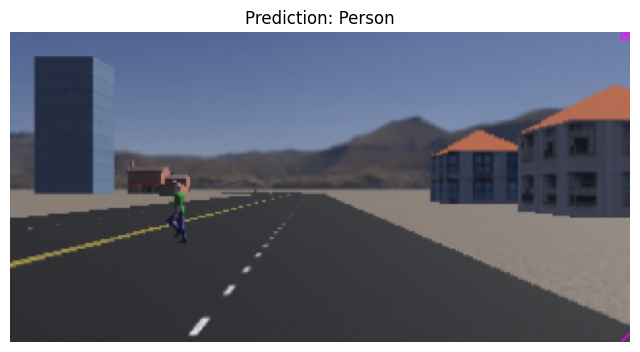

Image: Captura de pantalla 2025-06-20 a la(s) 4.38.00 p.m..png
Prediction: Person detected
----------------------


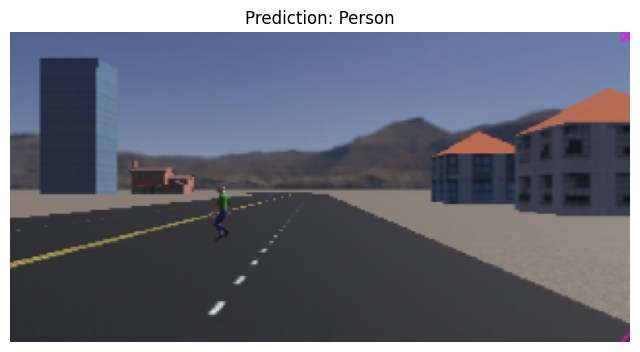

Image: Captura de pantalla 2025-06-20 a la(s) 4.37.24 p.m..png
Prediction: Person detected
----------------------


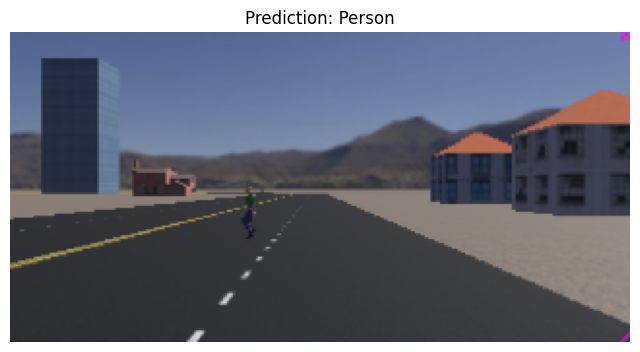

Image: Captura de pantalla 2025-06-20 a la(s) 4.26.31 p.m..png
Prediction: Person detected
----------------------


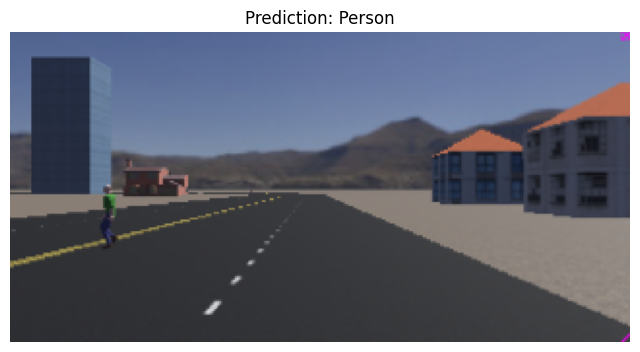

Image: Captura de pantalla 2025-06-20 a la(s) 4.38.49 p.m..png
Prediction: Person detected
----------------------


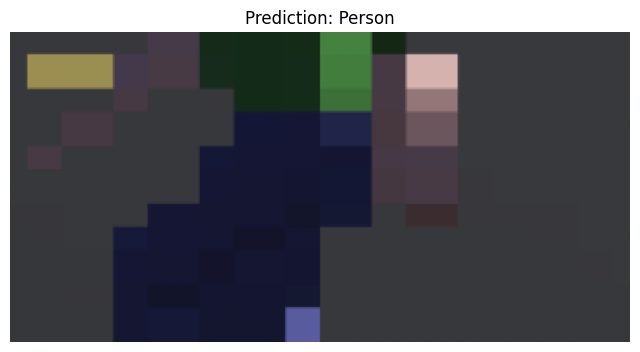

Image: Captura de pantalla 2025-06-20 a la(s) 4.03.43 p.m..png
Prediction: Person detected
----------------------


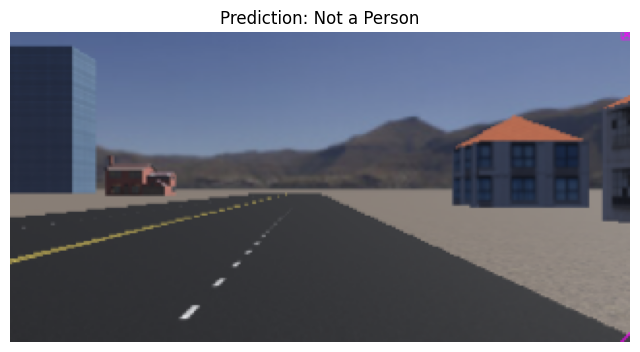

Image: Captura de pantalla 2025-06-20 a la(s) 5.04.05 p.m..png
Prediction: No person detected
----------------------


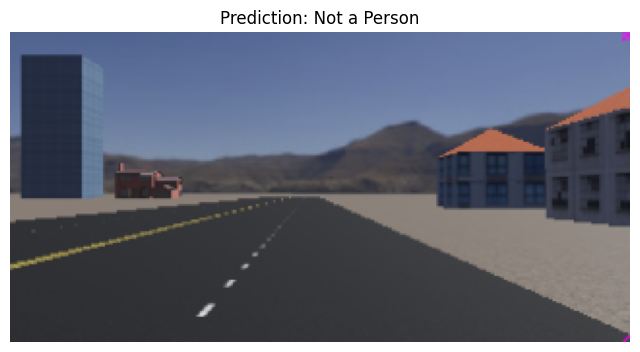

Image: Captura de pantalla 2025-06-20 a la(s) 4.41.42 p.m..png
Prediction: No person detected
----------------------


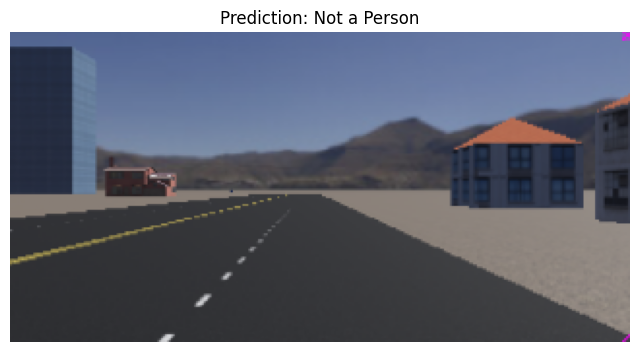

Image: Captura de pantalla 2025-06-20 a la(s) 5.03.54 p.m..png
Prediction: No person detected
----------------------


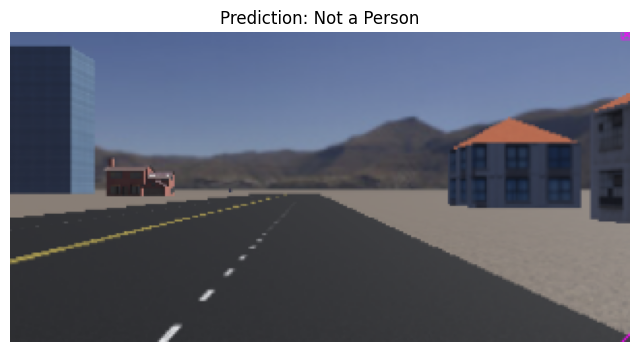

Image: Captura de pantalla 2025-06-20 a la(s) 5.03.49 p.m..png
Prediction: No person detected
----------------------


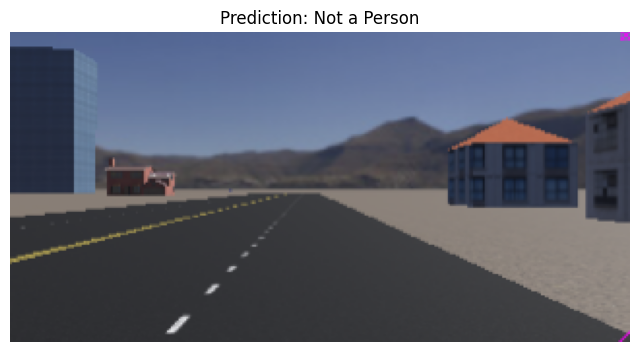

Image: Captura de pantalla 2025-06-20 a la(s) 5.03.42 p.m..png
Prediction: No person detected
----------------------


In [25]:

# Test on new images
people_dir = '/Users/charliepano/Desktop/navegacion-autonoma-equipo23/Actividad3/data_copy/people'
non_people_dir = '/Users/charliepano/Desktop/navegacion-autonoma-equipo23/Actividad3/data_copy/non-people'

# Get first 5 images from each directory
test_images = [os.path.join(people_dir, f) for f in os.listdir(people_dir) if f.endswith(('.jpg', '.jpeg', '.png'))][:5]
test_images += [os.path.join(non_people_dir, f) for f in os.listdir(non_people_dir) if f.endswith(('.jpg', '.jpeg', '.png'))][:5]

print("\nTesting on new images:")
print("----------------------")

for img_path in test_images:
    # Load and preprocess image
    img_color = mpimg.imread(img_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features
    img_hog_feature, _ = hog(img_gray,
                            orientations = 11,
                            pixels_per_cell = (16,16),
                            cells_per_block = (2,2),
                            transform_sqrt = False,
                            visualize = True,
                            feature_vector = True)
    
    # Reshape features for prediction
    img_hog_feature = img_hog_feature.reshape(1, -1)
    
    # Make prediction
    prediction = svc_model.predict(img_hog_feature)
    
    # Display result
    plt.figure(figsize=(8,6))
    plt.imshow(img_color)
    plt.title(f"Prediction: {'Person' if prediction[0] == 1 else 'Not a Person'}")
    plt.axis('off')
    plt.show()
    
    # Print the result
    print(f"Image: {os.path.basename(img_path)}")
    print(f"Prediction: {'Person detected' if prediction[0] == 1 else 'No person detected'}")
    print("----------------------")